In [1]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import scipy.ndimage
import scipy.signal

from PIL import Image
from shutil import copyfile

In [2]:
# directory = '/Volumes/OGA16_ESP/East_Shetland_Platform/01. RAW PSTM STACKS/10. FULL STACKS'
directory = 'C:\\Users\peter\Desktop\Bootcamp\Segy1\*'
glob.glob(directory)
# directory = '/Users/Mikey/Documents/Workspace/segy'

['C:\\Users\\peter\\Desktop\\Bootcamp\\Segy1\\ESP2D_FINAL_FULL_KPSTM_STACK_008A094.segy',
 'C:\\Users\\peter\\Desktop\\Bootcamp\\Segy1\\ESP2D_RAW_FULL_KPSTM_STACK_008A094.segy']

In [3]:
def gersztenkorn_eigenstructure(region):
    # Once again, stack all of the traces into one 2D array.
    # region = region.reshape(-1, region.shape[-1])

    cov = region.dot(region.T)
    vals = np.linalg.eigvalsh(cov)
    return vals.max() / vals.sum()

In [4]:
def moving_window(data, window, func):
    # `generic_filter` will give the function 1D input. We'll reshape it for convinence
    wrapped = lambda region: func(region.reshape(window))
    
    # Instead of an explicit for loop, we'll use a scipy function to do the same thing
    # The boundaries will be handled by "reflecting" the data, by default
    return scipy.ndimage.generic_filter(data, wrapped, window)

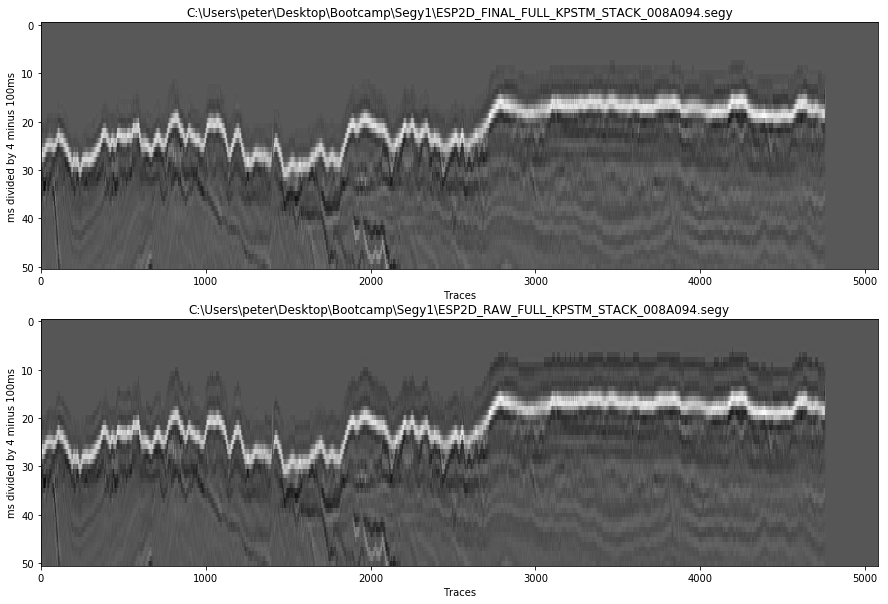

In [5]:
#"""Plot up the data"""
fig,axes=plt.subplots(figsize=(15,10),nrows=2)

for file,ax in zip(glob.glob(directory),axes):

    with segyio.open(file) as segyfile:

        traces = len(segyfile.trace)
        samples = 51
        fsamples = 501

        data = np.zeros([traces, samples])
        fdata = np.zeros([traces, fsamples])

        i = 0
        for trace in segyfile.trace:
            data[i,:] = np.asarray(trace[25:76] * 1.0)
            i += 1

        data = data.T
        fdata = fdata.T
        
        ax.imshow(data[:], vmin = np.min(data)/1, vmax = np.max(data)/1, aspect='auto', cmap='gray')
        ax.set_xlabel('Traces')
        ax.set_ylabel('ms divided by 4 minus 100ms')
#        ax.set_ylabel('ms divided by 4')

        ax.set_title(file)        

In [ ]:
#"""Plot up the real fourier transform"""
fig,axes=plt.subplots(figsize=(15,10),nrows=2)

for file,ax in zip(glob.glob(directory),axes):

    with segyio.open(file) as segyfile:

        traces = len(segyfile.trace)
        samples = 1001
        fsamples = 501

        data = np.zeros([traces, samples])
        fdata = np.zeros([traces, fsamples])

        i = 0
        for trace in segyfile.trace:
            data[i,:] = np.asarray(trace[0:1001] * 1.0)
            fdata[i,:] = np.fft.rfft(data[i,:])
            i += 1

        data = data.T
        fdata = fdata.T
        
        ax.set_xlabel('Traces')
        ax.set_ylabel('ms divided by 4')
        ax.set_title(file)
        ax.imshow(np.abs(fdata[:]), vmin = 0, vmax = np.max(fdata), aspect='auto', cmap='rainbow')
        ax.set_ylabel('Frequencies times by 4')
        

C:\Users\peter\Anaconda3\envs\geocomp\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


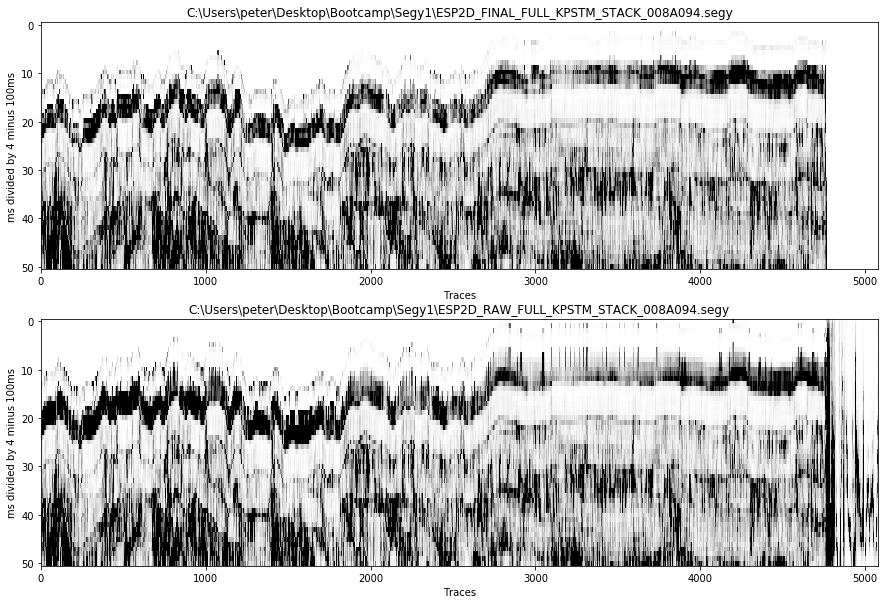

In [6]:
#"""Plot up the Gersztenkorn semblance"""
fig,axes=plt.subplots(figsize=(15,10),nrows=2)

for file,ax in zip(glob.glob(directory),axes):

    with segyio.open(file) as segyfile:

        traces = len(segyfile.trace)
        samples = 1001
        gsamples = 51

        data = np.zeros([traces, gsamples])

        i = 0
        for trace in segyfile.trace:
            data[i,:] = np.asarray(trace[25:76] * 1.0)
            i += 1

        data = data.T
                
        gersztenkorn = moving_window(data, (5, 5), gersztenkorn_eigenstructure)

        ax.imshow(gersztenkorn, vmin = 0.9, vmax = 1, aspect='auto', cmap='gray')
        ax.set_xlabel('Traces')
        ax.set_ylabel('ms divided by 4 minus 100ms')
        ax.set_title(file)


C:\Users\peter\Anaconda3\envs\geocomp\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


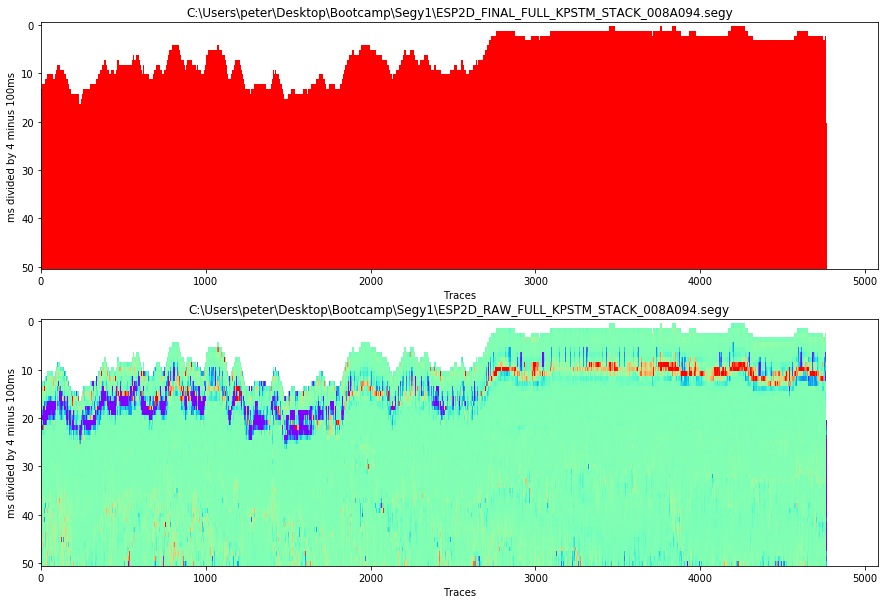

In [7]:
#"""Plot up the Gersztenkorn difference"""
fig,axes=plt.subplots(figsize=(15,10),nrows=2)
j = 0
for file,ax in zip(glob.glob(directory),axes):

    with segyio.open(file) as segyfile:

        traces = len(segyfile.trace)
        samples = 1001
        gsamples = 51

        data = np.zeros([traces, gsamples])
        if j < 1:
             first = np.zeros([gsamples, traces])

        i = 0
        for trace in segyfile.trace:
            data[i,:] = np.asarray(trace[25:76] * 1.0)
            i += 1

        data = data.T
        
        gersztenkorn = moving_window(data, (5, 5), gersztenkorn_eigenstructure)
        diff = gersztenkorn - first
        first = gersztenkorn

        ax.imshow(diff, vmin = -0.1, vmax = 0.1, aspect='auto', cmap='rainbow')
        ax.set_xlabel('Traces')
        ax.set_ylabel('ms divided by 4 minus 100ms')
        ax.set_title(file)

        j += 1
        